# Requirements

In [8]:
import os
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import cv2

#custom
import saliency.core as saliency
import pickle
import itertools

# Dataset loader

In [9]:
train_dir = 'hmt_dataset/HMT_train' #you should change to your directory
test_dir = 'hmt_dataset/HMT_test' #you should change to your directory

train_datagen = ImageDataGenerator(rescale=1/255.,
shear_range=0.1,
rotation_range=15,
horizontal_flip=True,
vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=False)

Found 4504 images belonging to 8 classes.
Found 496 images belonging to 8 classes.


Overrided

# Create Model

In [10]:
weight_decay = 5e-4
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten?

#model.add(Flatten())
model.add(GlobalAveragePooling2D())
#model.add(Dense(1024, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
#                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(8, activation='softmax', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                  

# Training

In [12]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='sgd',
              metrics=['accuracy'])

In [13]:
def lr_scheduler(epoch):
    base_ep = 15
    return 1e-3 * (.5 ** (epoch // base_ep))
lr_reduce_cb = keras.callbacks.LearningRateScheduler(lr_scheduler)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir='log', write_graph=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, min_delta=0.)

In [14]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

In [15]:
fit_out = model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.n // 32,
                    epochs=150,
                    callbacks=[tensorboard_cb],                  
                    shuffle = True,
                    verbose=1)

history = fit_out.history
#pickle history
with open('log/train/history.pkl', 'wb') as f:
    pickle.dump(history, f)

C:\Users\nich_\AppData\Local\Temp\ipykernel_27068\528426752.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit_out = model.fit_generator(generator=train_generator,


Epoch 1/150
140/140 [==============================] - 55s 362ms/step - loss: 2.0088 - accuracy: 0.2077
Epoch 2/150
140/140 [==============================] - 50s 353ms/step - loss: 1.6390 - accuracy: 0.3640
Epoch 3/150
140/140 [==============================] - 49s 351ms/step - loss: 1.4197 - accuracy: 0.4463
Epoch 4/150
140/140 [==============================] - 49s 350ms/step - loss: 1.2890 - accuracy: 0.4859
Epoch 5/150
140/140 [==============================] - 50s 355ms/step - loss: 1.1985 - accuracy: 0.5275
Epoch 6/150
140/140 [==============================] - 51s 362ms/step - loss: 1.1149 - accuracy: 0.5776
Epoch 7/150
140/140 [==============================] - 48s 345ms/step - loss: 1.1092 - accuracy: 0.5803
Epoch 8/150
140/140 [==============================] - 48s 345ms/step - loss: 1.1181 - accuracy: 0.5926
Epoch 9/150
140/140 [==============================] - 47s 336ms/step - loss: 1.0555 - accuracy: 0.6031
Epoch 10/150
140/140 [==============================] - 47s 336m

In [16]:
model.save('HMT.h5')

# Load Model

In [17]:
with open('log/train/history.pkl', 'rb') as f:
    history = pickle.load(f)

model=load_model('models/HMT.h5')

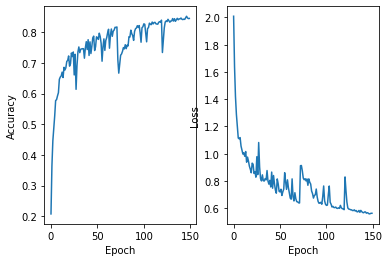

Found 496 images belonging to 8 classes.
Overall
16/16 [==============================] - 1s 36ms/step - loss: 0.5554 - accuracy: 0.8347
Classwise
Found 496 images belonging to 8 classes.
2/2 [==============================] - 0s 32ms/step - loss: 0.2352 - accuracy: 1.0000


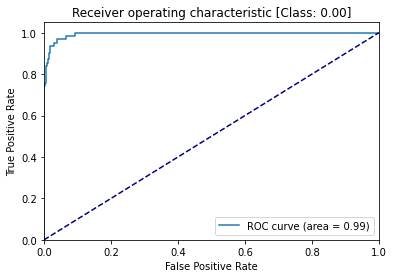

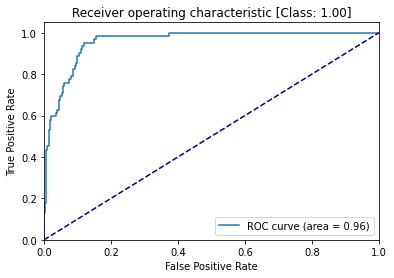

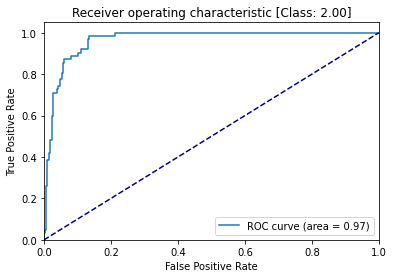

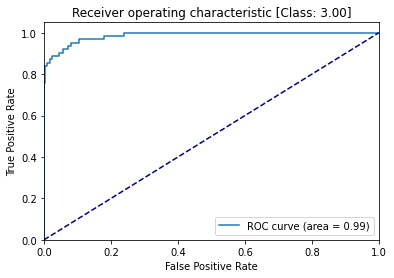

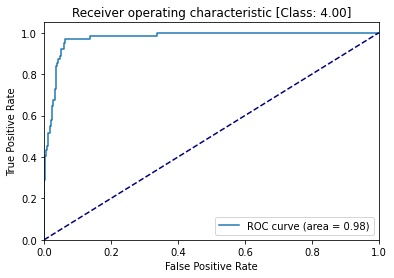

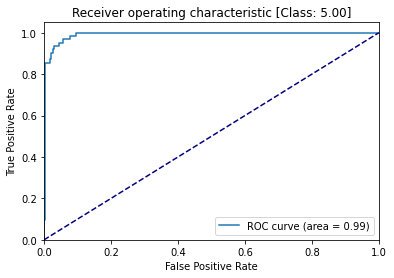

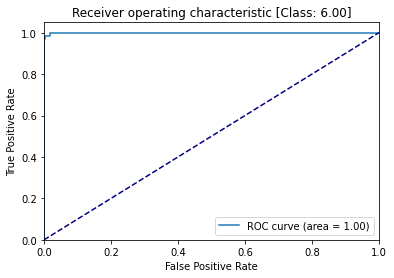

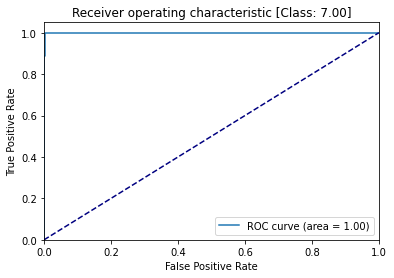

Class: Tumor
Precision: 0.8548387096774194
Recall: 0.9298245614035088
F1: 0.8907563025210085

Class: Stroma
Precision: 0.7580645161290323
Recall: 0.6103896103896104
F1: 0.6762589928057554

Class: Complex
Precision: 0.7741935483870968
Recall: 0.6666666666666666
F1: 0.7164179104477612

Class: Lympho
Precision: 0.8548387096774194
Recall: 0.9298245614035088
F1: 0.8907563025210085

Class: Debris
Precision: 0.6612903225806451
Recall: 0.7454545454545455
F1: 0.7008547008547009

Class: Mucosa
Precision: 0.8225806451612904
Recall: 0.9444444444444444
F1: 0.8793103448275862

Class: Adiopse
Precision: 0.9516129032258065
Recall: 1.0
F1: 0.9752066115702479

Class: Empty
Precision: 1.0
Recall: 0.9538461538461539
F1: 0.9763779527559054

Macro Precision: 0.8346774193548387
Macro Recall: 0.8475563179510548
Macro F1: 0.8382423897879967


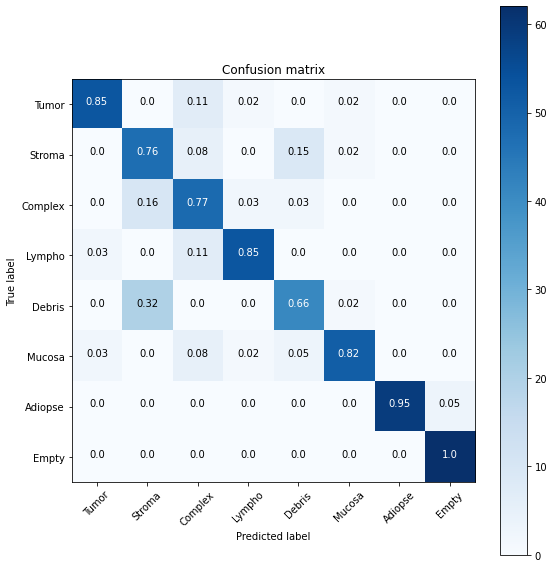

In [19]:
plt.subplot(121)
plt.plot(history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.subplot(122)
plt.plot(history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

# generate some test data
test_generator.reset()
image_batch,label_batch=test_generator.next()
#print(label_batch.shape)
class_names=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']

#overall

# generate evaluation data

eval_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=496,
shuffle=True)

print('Overall')

eval_generator.reset()
image_batch,label_batch=eval_generator.next()
model.evaluate(image_batch,label_batch)

print('Classwise')

class_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=62,
shuffle=False)

for i in range(8):
    image_batch,label_batch=class_generator.next()
    model.evaluate(image_batch,label_batch)
    
# roc, auc

eval_generator.reset()
image_batch, y_test=eval_generator.next()
y_score = model.predict(image_batch)
y_pred = np.argmax(y_score, axis=1)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(8):
    
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
    plt.plot(fpr[i], tpr[i], label="ROC curve (area = %0.2f)" % roc_auc[i])
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic [Class: %0.2f]" % i)
    plt.legend(loc="lower right")
    plt.show()
    
# normalized confusion matrix

y_test_nonbin = np.argmax(y_test, axis=1)

cm = tensorflow.math.confusion_matrix(y_test_nonbin, y_pred, num_classes=8).numpy()

figure = plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Normalize the confusion matrix.
cm_n = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

# Use white text if squares are dark; otherwise black.
threshold = cm_n.max() / 2.

for i, j in itertools.product(range(cm_n.shape[0]), range(cm_n.shape[1])):
    color = "white" if cm_n[i, j] > threshold else "black"
    plt.text(j, i, cm_n[i, j], horizontalalignment="center", color=color)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Precision/Recall/F-1
precision = []
recall = []
f_1 = []
for i in range(8):
    precision.append(float(cm[i, i])/float(sum(cm[i, :])))
    recall.append(float(cm[i, i])/float(sum(cm[:, i])))
    f_1.append(2*precision[i]*recall[i]/(precision[i] + recall[i]))
    print(f'Class: {class_names[i]}')
    print(f'Precision: {precision[i]}')
    print(f'Recall: {recall[i]}')
    print(f'F1: {f_1[i]}')
    print()
    
print(f'Macro Precision: {sum(precision)/len(precision)}')
print(f'Macro Recall: {sum(recall)/len(recall)}')
print(f'Macro F1: {sum(f_1)/len(f_1)}')



# Explanation

Load the explaier library

In [144]:
from xai_utils import *

Load a batch of images

In [145]:
test_generator.reset()

In [146]:
image_batch,label_batch=test_generator.next()

Classes:

In [147]:
classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']

Predict a single image

In [148]:
index=8

In [149]:
prediction=model(image_batch)

pred_class_idx = np.argmax(prediction[index])
print('True label: '+classes[np.argmax(label_batch[index])])
print('Predicted_label: '+classes[pred_class])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))

True label: Tumor
Predicted_label: Stroma
Confidence score for the correct label: 0.9661708


Generate explanation map

## SISE (Semantic Input Sampling for Explanation)

Set the layer(s)

In [150]:
layers=[['conv2d_3']]

In [151]:
%%time
explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=pred_class_idx, grad_thr=0.)
explanation_map_SISE -= explanation_map_SISE.min()
explanation_map_SISE /= explanation_map_SISE.max()+10e-30

CPU times: total: 203 ms
Wall time: 195 ms


## SmoothGrad

In [152]:
gradient_saliency = saliency.GradientSaliency()

def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args['class_idx']
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)

            output_layer = model(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}
        
smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(image_batch[index], call_model_function, {'class_idx': pred_class_idx}) 
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

## Plot the results

Text(0.5, 1.0, 'Explanation map (SmoothGrad)')

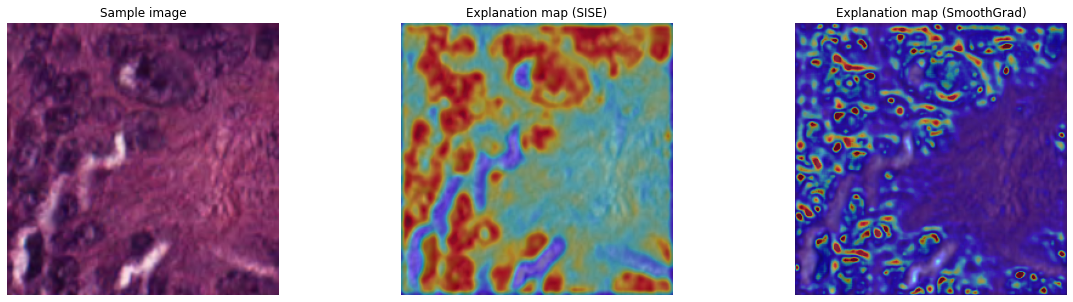

In [153]:
#@title Plot the results

plt.figure(figsize=(20,5))

plt.subplot(131)
plt.imshow(image_batch[index])
plt.axis('off')
plt.title('Sample image')

plt.subplot(132)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_SISE, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (SISE)')

plt.subplot(133)
plt.imshow(image_batch[index])
plt.imshow(smoothgrad_mask_grayscale, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (SmoothGrad)')

## Quantitative evaluation of the explanation algorithm

In [ ]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    # Pre-processing image 
    img=images[0,:,:,:]
    img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,224,224,3))
    exmap1_thr[0,:,:,0]=img[0,:,:,0]*exmap1_msk
    exmap1_thr[0,:,:,1]=img[0,:,:,1]*exmap1_msk
    exmap1_thr[0,:,:,2]=img[0,:,:,2]*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [ ]:
val_generator.reset()
drop_rate = 0.
for _ in range(15):
    image_batch,label_batch=val_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
        drop_rate += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_SISE, class_index=np.argmax(prediction[index]), frac=0.9)[0]
drop_rate /= (15*32)